In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests
import holidays

from pandas import CategoricalDtype
from bs4 import BeautifulSoup
from datetime import date
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid, GridSearchCV
from scipy import stats

import sys
import os

backend_path = os.path.abspath('../backend')
sys.path.append(backend_path)
from get_metrics import get_metrics



# Parcing data

In [70]:
# парсинг ключевой ставки в df
URL = 'https://www.cbr.ru/hd_base/keyrate/?UniDbQuery.Posted=True&UniDbQuery.From=17.09.2013&UniDbQuery.To=' + date.today().strftime('%d.%m.%Y')

data = requests.get(URL).text

bs4 = BeautifulSoup(data, "html.parser")
table = bs4.find_all("table")

df = pd.read_html(str(table))[0]
df.iloc[:,1:] /= 100

C:\Users\myxa-\AppData\Local\Temp\ipykernel_9048\165983360.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]
C:\Users\myxa-\AppData\Local\Temp\ipykernel_9048\165983360.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0       16.0
1       16.0
2       16.0
3       16.0
4       16.0
        ... 
2631     5.5
2632     5.5
2633     5.5
2634     5.5
2635     5.5
Name: Ставка, Length: 2636, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:,1:] /= 100


In [71]:
# преобразование столбца дата в формат datetime
df['Дата'] = pd.to_datetime(df['Дата'], dayfirst=True)

# перенаименование столбцов
df.columns = ['date', 'key_rate']

In [72]:
# общая информацию о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2636 entries, 0 to 2635
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      2636 non-null   datetime64[ns]
 1   key_rate  2636 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 41.3 KB


In [73]:
# основные описательные статистики для числовых признаков
df.iloc[:, 1:].describe()

,key_rate
count,2636.000000
mean,8.710831
std,3.176341
min,4.250000
25%,7.000000
50%,7.750000
75%,10.500000
max,20.000000


In [74]:
df[:5]

,date,key_rate
0,2024-04-05,16.0
1,2024-04-04,16.0
2,2024-04-03,16.0
3,2024-04-02,16.0
4,2024-04-01,16.0


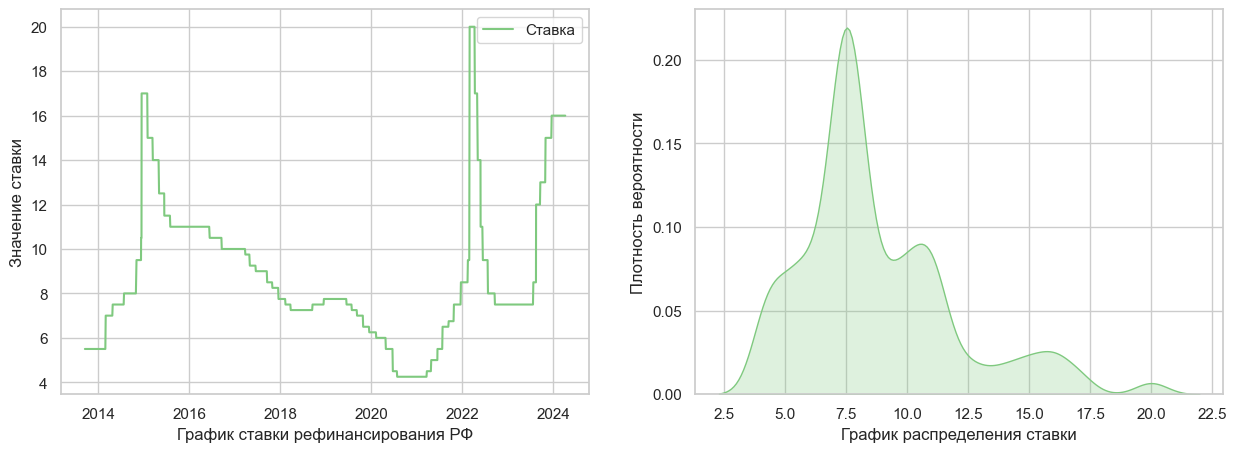

In [75]:
# рисуем график курса ключевой ствки ЦБ РФ и график распределения
figure, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.set_theme(style="whitegrid", palette="Accent")

sns.lineplot(x='date', y='key_rate', data=df, label='Ставка', ax=axes[0])
axes[0].set_xlabel('График ставки рефинансирования РФ')
axes[0].set_ylabel('Значение ставки')
axes[0].legend(loc='best')
axes[0].grid(True)

sns.kdeplot(x=df['key_rate'], ax=axes[1], fill=True)
axes[1].grid(True)
axes[1].set_xlabel('График распределения ставки')
axes[1].set_ylabel('Плотность вероятности')
plt.show()

# EDA

In [76]:
# проверка на нормальное или ненормальное распределение.
test_shapiro = stats.shapiro(df['key_rate'])

print(test_shapiro)

if test_shapiro.pvalue < 0.05:
    print('Распределение не нормальное')
else:
    print('Распределение нормальное')

ShapiroResult(statistic=0.9034788074280334, pvalue=6.173642881803165e-38)
Распределение не нормальное


In [77]:
def create_features(data, col_datetime):
    """Создание сезонов и дней недели"""

    data = data.copy()
    data['weekday'] = data[col_datetime].dt.day_name().astype(cat_day)
    data['month'] = data[col_datetime].dt.month_name().astype(cat_month)
    data['year'] = data[col_datetime].dt.year
    data['quarter'] = data['date'].dt.quarter
    data['date_offset'] = (data[col_datetime].dt.month * 100 + data.date.dt.day - 320) % 1300
    data['season'] = data[col_datetime].dt.month.map({1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Autumn', 10: 'Autumn', 11: 'Autumn', 12: 'Winter'})
    
    return data

cat_day = CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered= True)
cat_month = CategoricalDtype(categories=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], ordered= True)

df_features = create_features(data=df, col_datetime='date')

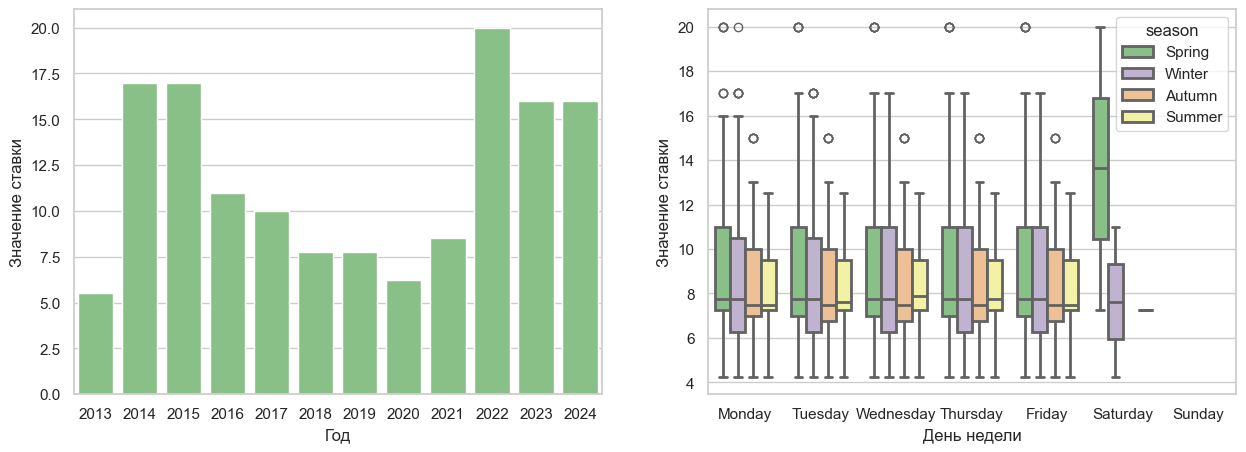

In [78]:
# рисуем графики для анализа
figure, axes = plt.subplots(1, 2, figsize=(15, 5))

year_group = pd.DataFrame(df_features.groupby('year')['key_rate'].max()).reset_index().sort_values('key_rate')

sns.barplot(data=year_group, x='year', y='key_rate', ax=axes[0])
axes[0].set_xlabel('Год')
axes[0].set_ylabel('Значение ставки')

sns.boxplot(data=df_features, x='weekday', y='key_rate', hue='season', ax=axes[1], linewidth=2)
axes[1].set_xlabel('День недели')
axes[1].set_ylabel('Значение ставки')

plt.show()



In [79]:
# дропаем редкие субботние ключевые ставки
drop_trash = df_features[(df_features.weekday == 'Saturday')].index
df = df[~df.index.isin(drop_trash)]
df = df.reset_index(drop=True)

In [80]:
# перенаименование названия колонок для prophet
df.columns = ['ds', 'y']

# период, который надо отрезать и предсказать (проверка модели)
pred_days = int(df.shape[0]*0.1)


In [81]:
# сортируем данные по возрастанию для корректного отображения разделения графика
df = df.sort_values('ds')
df = df.reset_index(drop=True)

In [82]:
# разделение данных на train, test
df_train = df[:-pred_days]
df_test = df[-pred_days:]


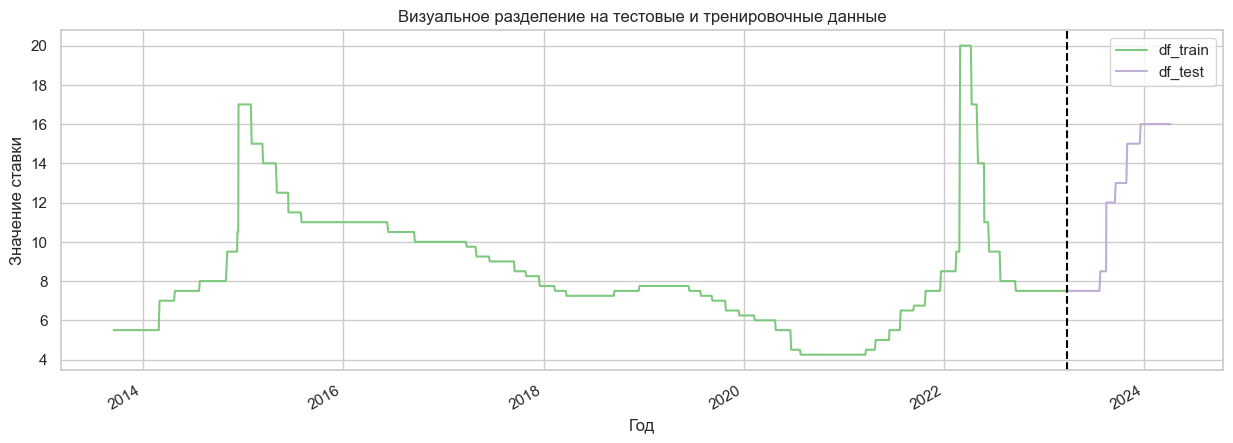

In [83]:
#отображаем график с разделением train, test для наглядности
fig, ax = plt.subplots(figsize = (10, 5))

fig.set_figheight(5)
fig.set_figwidth(15)
df_train.set_index('ds').plot(ax=ax, label= 'train', title='Визуальное разделение на тестовые и тренировочные данные')
df_test.set_index('ds').plot(ax=ax, label='test')
ax.axvline(df_train['ds'][-1:].values, ls='--', color='black')
ax.legend(['df_train', 'df_test'])
ax.set_ylabel('Значение ставки')
ax.set_xlabel('Год')
plt.show()

In [84]:
# обучение модели на train
model = Prophet()
model.fit(df_train)

00:53:07 - cmdstanpy - INFO - Chain [1] start processing
00:53:07 - cmdstanpy - INFO - Chain [1] done processing


In [85]:
future = model.make_future_dataframe(periods=pred_days, freq='D')
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2626,2023-12-08,11.775592,9.373634,14.116812
2627,2023-12-09,12.585713,10.180614,14.864558
2628,2023-12-10,12.635446,10.194984,15.073793
2629,2023-12-11,11.896726,9.531955,14.316184
2630,2023-12-12,11.953526,9.641463,14.242860


c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


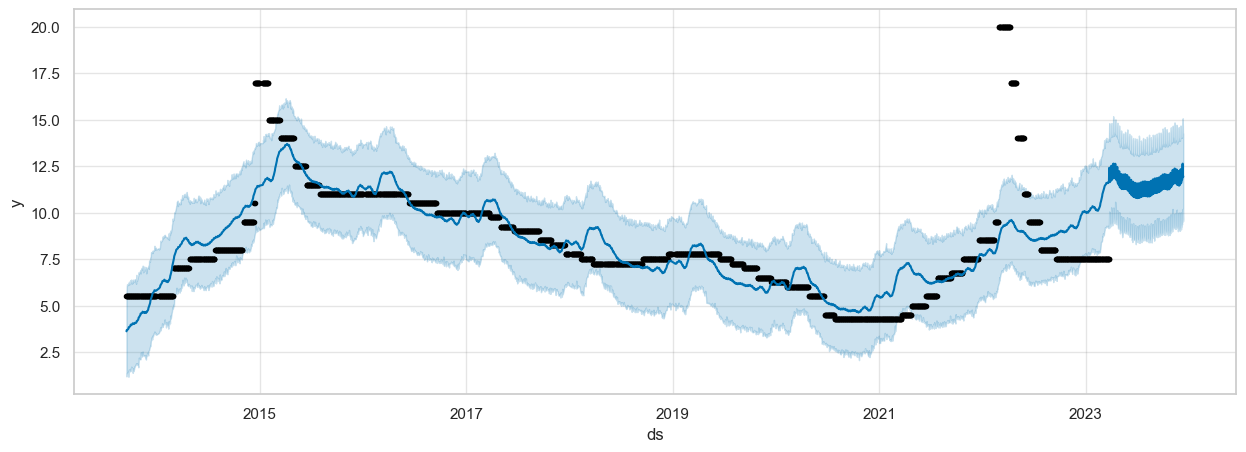

In [86]:
# смотрим график прогноза
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = model.plot(forecast,ax=ax)
plt.show()

c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series cont

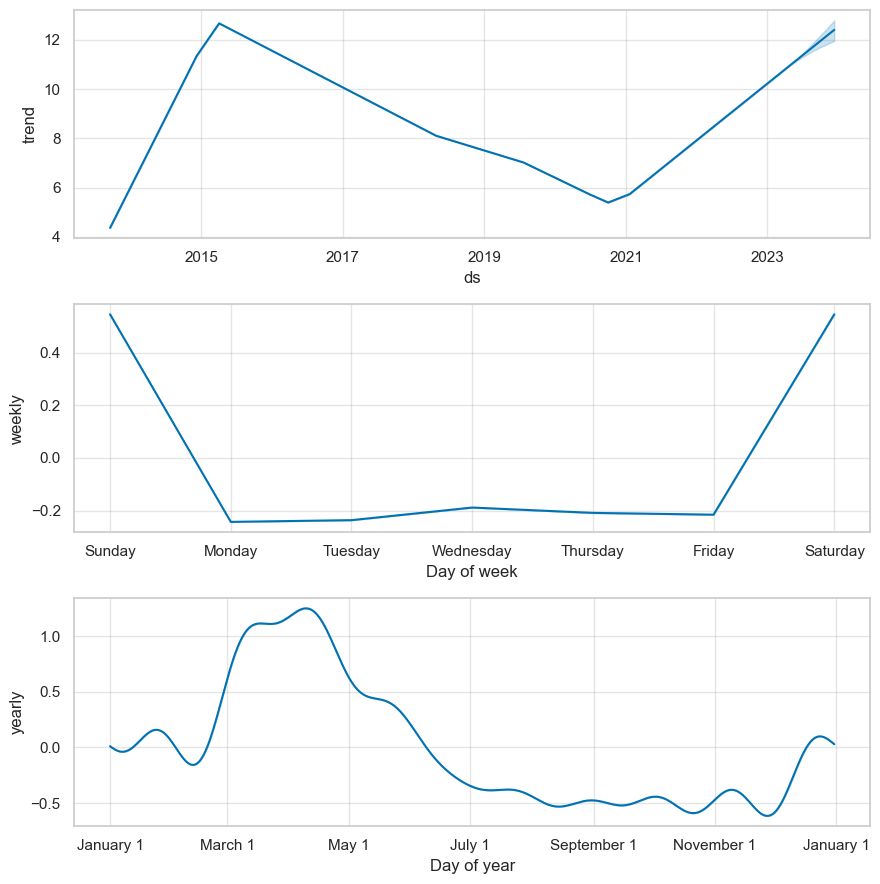

In [87]:
# смотрим тренд, годовые и сезонные признаки
fig = model.plot_components(forecast)
plt.show()

## Сравнение фактов и прогнозов

In [88]:
df_test_forecast = model.predict(df_test)
df_test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
258,2024-04-01,14.034320,11.602044,16.549930
259,2024-04-02,14.059922,11.572864,16.461953
260,2024-04-03,14.126794,11.749155,16.594223
261,2024-04-04,14.124895,11.543867,16.669655
262,2024-04-05,14.135389,11.779848,16.747119


c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


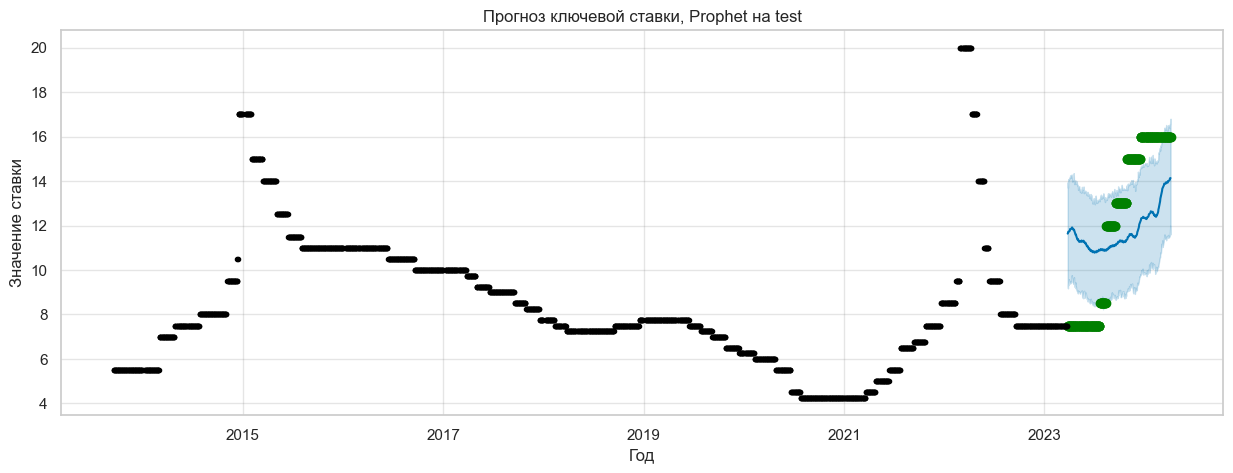

In [89]:
# смотрим совпадение фактического курса с предсказанным курсом prophet обученным на train, проверка модели
fig, ax = plt.subplots(figsize= (10, 5))

fig.set_figheight(5)
fig.set_figwidth(15)
predict = model.predict(df_test)
fig = model.plot(predict, ax=ax)
ax.scatter(df_test.ds, df_test['y'], color = 'g')
ax.set_title('Прогноз ключевой ставки, Prophet на test')
ax.set_ylabel('Значение ставки')
ax.set_xlabel('Год')
plt.show()

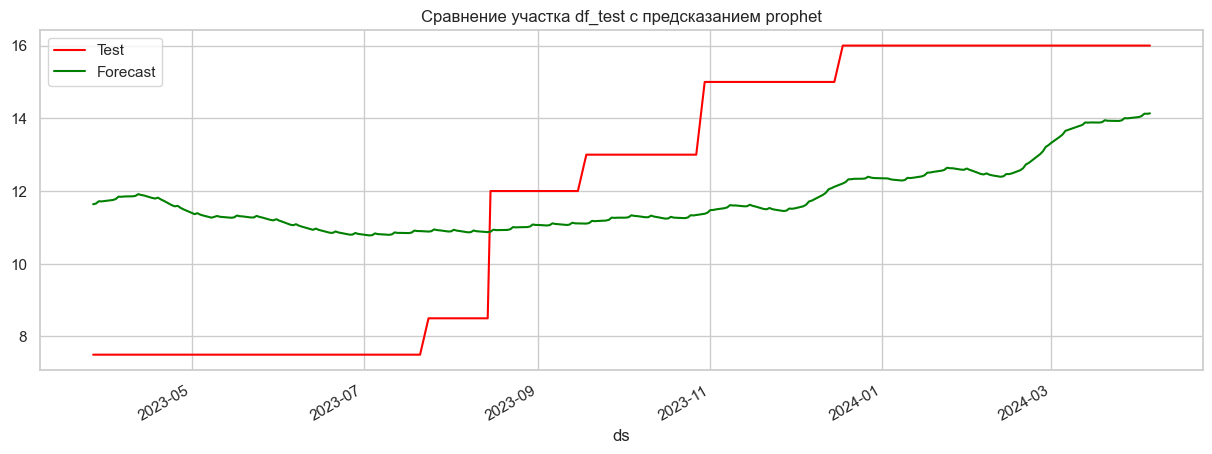

In [90]:
# сравнение участка df_test с предсказанием prophet
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet')
plt.show()

In [91]:
# просмотр метрик модели обученной на train в сравнени с прогнозом
metrics = get_metrics(y_test=df_test['y'], y_pred=df_test_forecast['yhat'], name='Prophet')
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet,2.933513,0.280977,9.560223,3.091961


Из приведенного выше графика мы видим, что существует разрыв в прогнозах и фактических данных. Поэтому нам нужно оптимизировать модель, добавив другие параметры, такие как праздники

In [92]:
# создаем df праздников в РФ начиная с 2013 по сегодня
holiday = pd.DataFrame([])
for date, name in sorted(holidays.Russia(years=[2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024]).items()):
    new_row = pd.DataFrame({'ds': date, 'holiday': "RU-Holidays"}, index=[0])
    holiday = pd.concat([holiday, new_row], ignore_index=True)  

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

C:\Users\myxa-\AppData\Local\Temp\ipykernel_9048\726342449.py:7: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')


In [93]:
# тренировка модели с праздниками
model_with_holidays = Prophet(holidays=holiday)
model_with_holidays.fit(df_train)

00:53:10 - cmdstanpy - INFO - Chain [1] start processing
00:53:11 - cmdstanpy - INFO - Chain [1] done processing


In [94]:
future = model_with_holidays.make_future_dataframe(periods=pred_days, freq='D')
forecast = model_with_holidays.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2626,2023-12-08,11.727308,9.392639,13.948077
2627,2023-12-09,12.537405,10.100149,14.924549
2628,2023-12-10,12.585744,10.020662,15.197054
2629,2023-12-11,11.839768,9.525928,14.181960
2630,2023-12-12,11.896646,9.697424,14.213848


c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


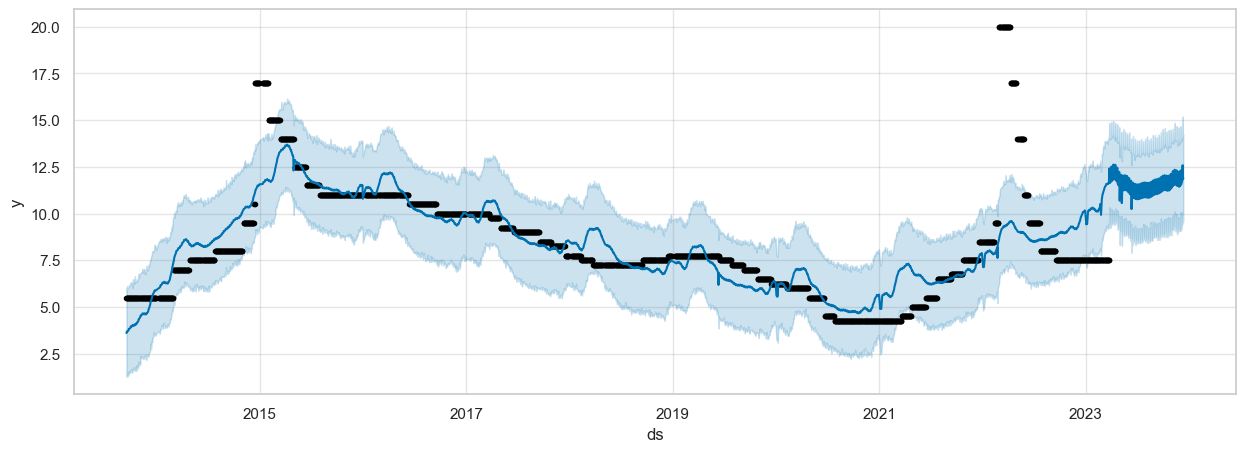

In [95]:
# смотрим график прогноза с праздниками
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = model_with_holidays.plot(forecast,ax=ax)
plt.show()

c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series cont

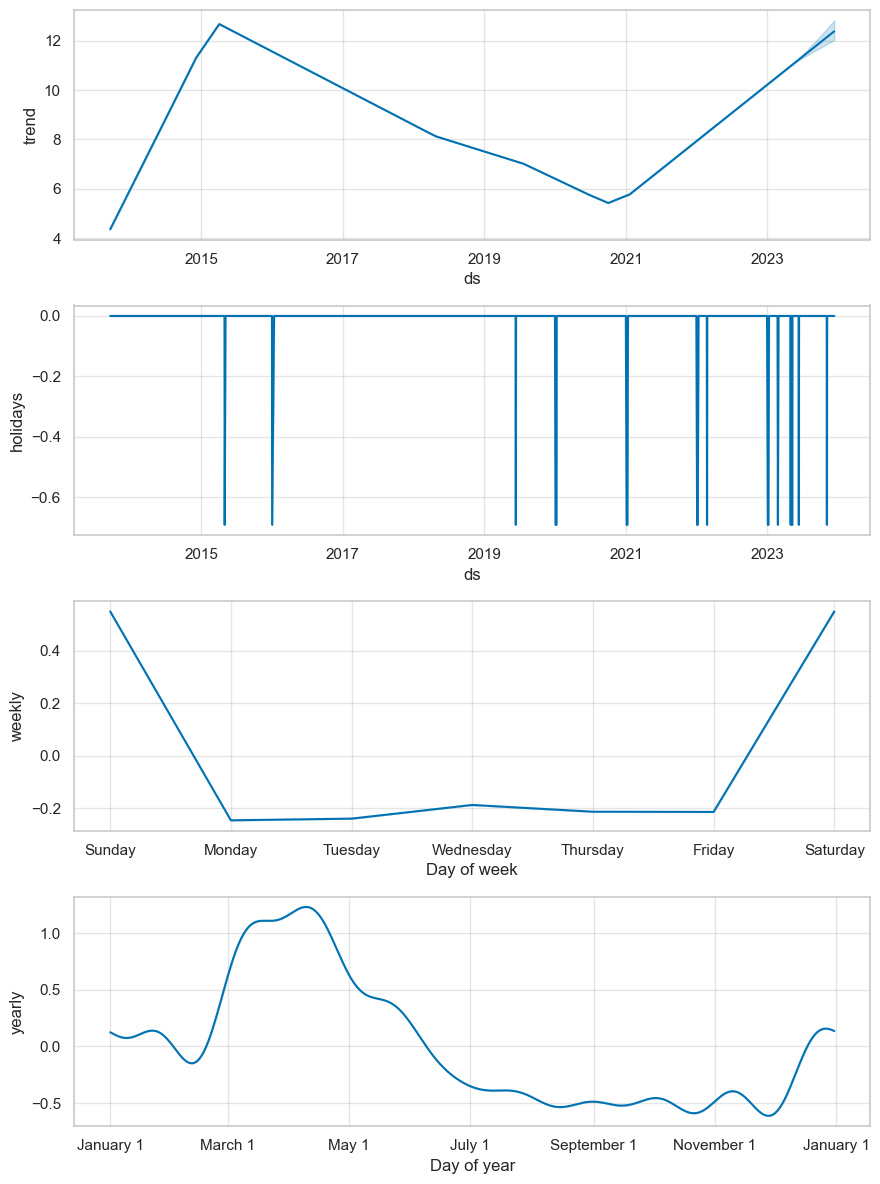

In [96]:
# смотрим тренд, годовые и сезонные признаки обученной модели с праздниками
fig = model_with_holidays.plot_components(forecast)
plt.show()

In [97]:
df_test_forecast_holiday = model_with_holidays.predict(df_test)
df_test_forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
258,2024-04-01,13.995771,11.464537,16.262178
259,2024-04-02,14.019589,11.522806,16.427489
260,2024-04-03,14.089046,11.612162,16.683887
261,2024-04-04,14.080160,11.509992,16.559180
262,2024-04-05,14.095332,11.444362,16.538425


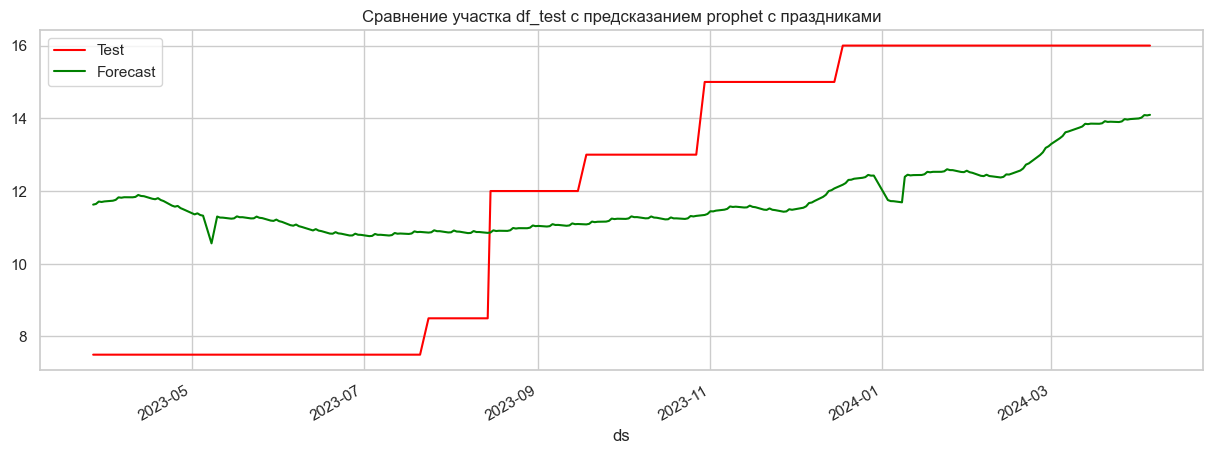

In [98]:
# сравнение участка df_test с предсказанием prophet
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast_holiday.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet с праздниками')
plt.show()

In [99]:
# сравниваем метрики после добавления в модель праздников 
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=df_test_forecast_holiday['yhat'], name='Prophet_with_holidays')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet,2.933513,0.280977,9.560223,3.091961
0,Prophet_with_holidays,2.947538,0.281309,9.635085,3.104043


Из метрик и графиков видим, что модель с праздниками показывает результаты немного хуже

# Тюнинг тест модели

In [100]:
# создание сетки параметров и подсчёт количества вариаций обучения
params_grid = {
    'changepoint_prior_scale':[0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 5, 10.0], 
    'holidays_prior_scale':[0.01, 0.1, 1.0, 5, 10.0],
    'seasonality_mode':('multiplicative','additive'),
               }
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Количество моделей для обучения по сетке:', cnt)

Количество моделей для обучения по сетке: 200


In [101]:
# Создаем пустой DataFrame с указанными столбцами
model_parameters = pd.DataFrame(columns=['MAPE', 'Parameters'])

# Проходимся по сетке гиперпараметров
for p in grid:
    print(p)
    
    # Создаем модель Prophet с текущими гиперпараметрами
    model_grid = Prophet(
        changepoint_prior_scale=p['changepoint_prior_scale'],
        seasonality_prior_scale=p['seasonality_prior_scale'],
        holidays_prior_scale=p['holidays_prior_scale'],
        seasonality_mode=p['seasonality_mode'],
        holidays=holiday,
    )

    # Добавляем праздники в модель
    model_grid.add_country_holidays(country_name='RU')

    # Обучаем модель данными
    model_grid.fit(df_train)

    # Создаем фрейм данных для предсказаний
    model_grid_future = model_grid.make_future_dataframe(periods=pred_days, freq='D', include_history=False)

    # Делаем предсказания
    model_grid_forecast = model_grid.predict(model_grid_future)

    # Вычисляем MAPE
    MAPE = mean_absolute_percentage_error(df_test['y'], model_grid_forecast['yhat'])
    print('Mean Absolute Percentage Error(MAPE) - ', MAPE)

    # Добавляем новую строку в DataFrame
    model_parameters = pd.concat([model_parameters, pd.DataFrame({'MAPE': [MAPE], 'Parameters': [p]})], ignore_index=True)

{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


00:53:14 - cmdstanpy - INFO - Chain [1] start processing
00:53:14 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\myxa-\AppData\Local\Temp\ipykernel_9048\201718003.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_parameters = pd.concat([model_parameters, pd.DataFrame({'MAPE': [MAPE], 'Parameters': [p]})], ignore_index=True)


Mean Absolute Percentage Error(MAPE) -  0.35659065599262524
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


00:53:14 - cmdstanpy - INFO - Chain [1] start processing
00:53:15 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.38099562023808153
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


00:53:15 - cmdstanpy - INFO - Chain [1] start processing
00:53:15 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.38099888478895644
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


00:53:16 - cmdstanpy - INFO - Chain [1] start processing
00:53:16 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3837226890025945
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


00:53:16 - cmdstanpy - INFO - Chain [1] start processing
00:53:17 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.38519101486511903
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


00:53:17 - cmdstanpy - INFO - Chain [1] start processing
00:53:17 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.36282488009111713
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


00:53:18 - cmdstanpy - INFO - Chain [1] start processing
00:53:18 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.41452660234935806
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


00:53:18 - cmdstanpy - INFO - Chain [1] start processing
00:53:18 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.4131327732960419
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


00:53:19 - cmdstanpy - INFO - Chain [1] start processing
00:53:19 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.41059625895234947
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


00:53:20 - cmdstanpy - INFO - Chain [1] start processing
00:53:20 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.41178691162200515
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


00:53:20 - cmdstanpy - INFO - Chain [1] start processing
00:53:20 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3569720908437023
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


00:53:21 - cmdstanpy - INFO - Chain [1] start processing
00:53:21 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3849107569279015
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


00:53:22 - cmdstanpy - INFO - Chain [1] start processing
00:53:22 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.384959162569244
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


00:53:22 - cmdstanpy - INFO - Chain [1] start processing
00:53:22 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3808099619888837
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


00:53:23 - cmdstanpy - INFO - Chain [1] start processing
00:53:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3800876980270331
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


00:53:24 - cmdstanpy - INFO - Chain [1] start processing
00:53:24 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3606046494508345
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


00:53:24 - cmdstanpy - INFO - Chain [1] start processing
00:53:24 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.41307551078796373
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


00:53:25 - cmdstanpy - INFO - Chain [1] start processing
00:53:25 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.4648840351691813
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


00:53:26 - cmdstanpy - INFO - Chain [1] start processing
00:53:26 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.40881939006010043
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


00:53:26 - cmdstanpy - INFO - Chain [1] start processing
00:53:27 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.405596732668386
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


00:53:27 - cmdstanpy - INFO - Chain [1] start processing
00:53:27 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3585304289362434
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


00:53:28 - cmdstanpy - INFO - Chain [1] start processing
00:53:28 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3851804286456356
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


00:53:28 - cmdstanpy - INFO - Chain [1] start processing
00:53:28 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.38513544381213394
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


00:53:29 - cmdstanpy - INFO - Chain [1] start processing
00:53:29 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.38081329426580096
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


00:53:30 - cmdstanpy - INFO - Chain [1] start processing
00:53:30 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.38157735665709447
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


00:53:30 - cmdstanpy - INFO - Chain [1] start processing
00:53:30 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3645387668742706
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


00:53:31 - cmdstanpy - INFO - Chain [1] start processing
00:53:31 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.41461729568349154
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


00:53:32 - cmdstanpy - INFO - Chain [1] start processing
00:53:32 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.4384644836986615
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


00:53:32 - cmdstanpy - INFO - Chain [1] start processing
00:53:33 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.4419426600608198
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


00:53:33 - cmdstanpy - INFO - Chain [1] start processing
00:53:33 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.4130700574062679
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


00:53:34 - cmdstanpy - INFO - Chain [1] start processing
00:53:34 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.358969353620744
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


00:53:34 - cmdstanpy - INFO - Chain [1] start processing
00:53:34 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.38515525135400047
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


00:53:35 - cmdstanpy - INFO - Chain [1] start processing
00:53:35 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.38517989504222594
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


00:53:36 - cmdstanpy - INFO - Chain [1] start processing
00:53:36 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.38092409906255154
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


00:53:36 - cmdstanpy - INFO - Chain [1] start processing
00:53:36 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3813364023770534
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


00:53:37 - cmdstanpy - INFO - Chain [1] start processing
00:53:37 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3628580396437278
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


00:53:38 - cmdstanpy - INFO - Chain [1] start processing
00:53:38 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.4177381456366619
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


00:53:38 - cmdstanpy - INFO - Chain [1] start processing
00:53:38 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.4568295169837409
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


00:53:39 - cmdstanpy - INFO - Chain [1] start processing
00:53:39 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.4100598425002575
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


00:53:40 - cmdstanpy - INFO - Chain [1] start processing
00:53:40 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.41720850262289894
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


00:53:40 - cmdstanpy - INFO - Chain [1] start processing
00:53:40 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.35880891828369843
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


00:53:41 - cmdstanpy - INFO - Chain [1] start processing
00:53:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3851528003222847
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


00:53:41 - cmdstanpy - INFO - Chain [1] start processing
00:53:42 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3851564098275304
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


00:53:42 - cmdstanpy - INFO - Chain [1] start processing
00:53:42 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3809389713126842
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


00:53:43 - cmdstanpy - INFO - Chain [1] start processing
00:53:43 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3814765497923226
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


00:53:43 - cmdstanpy - INFO - Chain [1] start processing
00:53:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3624821465574441
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


00:53:44 - cmdstanpy - INFO - Chain [1] start processing
00:53:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.41731254501744425
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


00:53:45 - cmdstanpy - INFO - Chain [1] start processing
00:53:45 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.4089686341817263
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


00:53:45 - cmdstanpy - INFO - Chain [1] start processing
00:53:46 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.41078675127062886
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


00:53:46 - cmdstanpy - INFO - Chain [1] start processing
00:53:46 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.4193152918036614
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


00:53:47 - cmdstanpy - INFO - Chain [1] start processing
00:53:47 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3263068848536579
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


00:53:48 - cmdstanpy - INFO - Chain [1] start processing
00:53:48 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5494409688891874
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


00:53:49 - cmdstanpy - INFO - Chain [1] start processing
00:53:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.8518980180236394
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


00:53:50 - cmdstanpy - INFO - Chain [1] start processing
00:53:50 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.8937842482106604
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


00:53:51 - cmdstanpy - INFO - Chain [1] start processing
00:53:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.8576743175060282
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


00:53:52 - cmdstanpy - INFO - Chain [1] start processing
00:53:52 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.32757443940285796
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


00:53:53 - cmdstanpy - INFO - Chain [1] start processing
00:53:53 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.33183485042804395
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


00:53:53 - cmdstanpy - INFO - Chain [1] start processing
00:53:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3314762192262956
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


00:53:54 - cmdstanpy - INFO - Chain [1] start processing
00:53:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3312573378861887
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


00:53:55 - cmdstanpy - INFO - Chain [1] start processing
00:53:55 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.33158175514727245
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


00:53:56 - cmdstanpy - INFO - Chain [1] start processing
00:53:56 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.32574760554951
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


00:53:56 - cmdstanpy - INFO - Chain [1] start processing
00:53:57 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5550555398445078
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


00:53:57 - cmdstanpy - INFO - Chain [1] start processing
00:53:58 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.85906814005715
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


00:53:58 - cmdstanpy - INFO - Chain [1] start processing
00:53:58 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.8542962584509762
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


00:53:59 - cmdstanpy - INFO - Chain [1] start processing
00:53:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.8576855341042945
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


00:54:00 - cmdstanpy - INFO - Chain [1] start processing
00:54:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.32886615674526914
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


00:54:01 - cmdstanpy - INFO - Chain [1] start processing
00:54:01 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.33229783764293375
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


00:54:01 - cmdstanpy - INFO - Chain [1] start processing
00:54:02 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.33203677916683216
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


00:54:02 - cmdstanpy - INFO - Chain [1] start processing
00:54:03 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.33200930588880917
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


00:54:03 - cmdstanpy - INFO - Chain [1] start processing
00:54:03 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.33168589207476684
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


00:54:04 - cmdstanpy - INFO - Chain [1] start processing
00:54:04 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.32737433097535446
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


00:54:05 - cmdstanpy - INFO - Chain [1] start processing
00:54:05 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.543114155418183
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


00:54:06 - cmdstanpy - INFO - Chain [1] start processing
00:54:06 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.8344162809539694
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


00:54:07 - cmdstanpy - INFO - Chain [1] start processing
00:54:07 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.8143925976445884
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


00:54:07 - cmdstanpy - INFO - Chain [1] start processing
00:54:08 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.8522527743218857
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


00:54:08 - cmdstanpy - INFO - Chain [1] start processing
00:54:09 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3289974485841118
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


00:54:09 - cmdstanpy - INFO - Chain [1] start processing
00:54:10 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3330239337939215
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


00:54:10 - cmdstanpy - INFO - Chain [1] start processing
00:54:11 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3327493079517795
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


00:54:11 - cmdstanpy - INFO - Chain [1] start processing
00:54:12 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.33217428864308984
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


00:54:12 - cmdstanpy - INFO - Chain [1] start processing
00:54:12 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.332583804059245
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


00:54:13 - cmdstanpy - INFO - Chain [1] start processing
00:54:13 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.32717843966116317
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


00:54:14 - cmdstanpy - INFO - Chain [1] start processing
00:54:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5495148401300285
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


00:54:15 - cmdstanpy - INFO - Chain [1] start processing
00:54:15 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.8762763630812682
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


00:54:16 - cmdstanpy - INFO - Chain [1] start processing
00:54:16 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.8548682532400655
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


00:54:16 - cmdstanpy - INFO - Chain [1] start processing
00:54:17 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.8671421558598214
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


00:54:17 - cmdstanpy - INFO - Chain [1] start processing
00:54:18 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3292875361145509
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


00:54:18 - cmdstanpy - INFO - Chain [1] start processing
00:54:18 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.33481608320709144
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


00:54:19 - cmdstanpy - INFO - Chain [1] start processing
00:54:19 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.33330201767386913
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


00:54:20 - cmdstanpy - INFO - Chain [1] start processing
00:54:20 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.332683789938264
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


00:54:20 - cmdstanpy - INFO - Chain [1] start processing
00:54:21 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.33269900800407726
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


00:54:21 - cmdstanpy - INFO - Chain [1] start processing
00:54:21 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3272064678553785
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


00:54:22 - cmdstanpy - INFO - Chain [1] start processing
00:54:22 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5559138277745231
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


00:54:23 - cmdstanpy - INFO - Chain [1] start processing
00:54:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.8897276335531378
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


00:54:24 - cmdstanpy - INFO - Chain [1] start processing
00:54:24 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.8650338634612978
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


00:54:25 - cmdstanpy - INFO - Chain [1] start processing
00:54:25 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.8182029446217856
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


00:54:26 - cmdstanpy - INFO - Chain [1] start processing
00:54:26 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.32942663638108144
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


00:54:26 - cmdstanpy - INFO - Chain [1] start processing
00:54:27 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3337480101528376
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


00:54:27 - cmdstanpy - INFO - Chain [1] start processing
00:54:28 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3326075825052569
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


00:54:28 - cmdstanpy - INFO - Chain [1] start processing
00:54:28 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3330393906961835
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


00:54:29 - cmdstanpy - INFO - Chain [1] start processing
00:54:29 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.33250714807429294
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


00:54:30 - cmdstanpy - INFO - Chain [1] start processing
00:54:30 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.32934022520099226
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


00:54:31 - cmdstanpy - INFO - Chain [1] start processing
00:54:31 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.4193284312696674
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


00:54:32 - cmdstanpy - INFO - Chain [1] start processing
00:54:34 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  1.0376181437366734
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


00:54:34 - cmdstanpy - INFO - Chain [1] start processing
00:54:37 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  1.1307319153829278
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


00:54:37 - cmdstanpy - INFO - Chain [1] start processing
00:54:40 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  1.1391589878946868
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


00:54:40 - cmdstanpy - INFO - Chain [1] start processing
00:54:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.32504899916542057
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


00:54:41 - cmdstanpy - INFO - Chain [1] start processing
00:54:42 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.32845068461027693
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


00:54:43 - cmdstanpy - INFO - Chain [1] start processing
00:54:43 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.32843584450954755
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


00:54:44 - cmdstanpy - INFO - Chain [1] start processing
00:54:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3287509363863404
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


00:54:45 - cmdstanpy - INFO - Chain [1] start processing
00:54:45 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3288502807478314
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


00:54:46 - cmdstanpy - INFO - Chain [1] start processing
00:54:46 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3290566595602097
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


00:54:47 - cmdstanpy - INFO - Chain [1] start processing
00:54:48 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.42197610264155466
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


00:54:48 - cmdstanpy - INFO - Chain [1] start processing
00:54:50 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  1.001976610888005
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


00:54:50 - cmdstanpy - INFO - Chain [1] start processing
00:54:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  1.1524212434908725
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


00:54:54 - cmdstanpy - INFO - Chain [1] start processing
00:54:58 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  1.1528947564452927
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


00:54:58 - cmdstanpy - INFO - Chain [1] start processing
00:54:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.32541311343242063
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


00:54:59 - cmdstanpy - INFO - Chain [1] start processing
00:55:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3282709298788369
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


00:55:00 - cmdstanpy - INFO - Chain [1] start processing
00:55:01 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.32858524213341916
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


00:55:01 - cmdstanpy - INFO - Chain [1] start processing
00:55:02 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.32883139388658084
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


00:55:02 - cmdstanpy - INFO - Chain [1] start processing
00:55:03 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3288741335100772
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


00:55:03 - cmdstanpy - INFO - Chain [1] start processing
00:55:04 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3299406893548304
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


00:55:05 - cmdstanpy - INFO - Chain [1] start processing
00:55:05 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.41536713501454664
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


00:55:06 - cmdstanpy - INFO - Chain [1] start processing
00:55:07 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.9732238919670236
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


00:55:07 - cmdstanpy - INFO - Chain [1] start processing
00:55:10 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  1.1684460633078781
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


00:55:11 - cmdstanpy - INFO - Chain [1] start processing
00:55:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  1.1764927542036883
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


00:55:14 - cmdstanpy - INFO - Chain [1] start processing
00:55:15 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3257618308055483
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


00:55:15 - cmdstanpy - INFO - Chain [1] start processing
00:55:16 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3288932184718948
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


00:55:16 - cmdstanpy - INFO - Chain [1] start processing
00:55:17 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3291849152330117
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


00:55:17 - cmdstanpy - INFO - Chain [1] start processing
00:55:18 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3293789997016217
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


00:55:18 - cmdstanpy - INFO - Chain [1] start processing
00:55:19 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3292951930696478
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


00:55:19 - cmdstanpy - INFO - Chain [1] start processing
00:55:20 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3299791463047103
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


00:55:21 - cmdstanpy - INFO - Chain [1] start processing
00:55:21 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.42182080368944463
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


00:55:22 - cmdstanpy - INFO - Chain [1] start processing
00:55:24 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  1.0415625073626533
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


00:55:25 - cmdstanpy - INFO - Chain [1] start processing
00:55:28 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  1.1660353112914075
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


00:55:29 - cmdstanpy - INFO - Chain [1] start processing
00:55:31 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  1.1580615867191515
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


00:55:32 - cmdstanpy - INFO - Chain [1] start processing
00:55:32 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.32569855908161843
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


00:55:33 - cmdstanpy - INFO - Chain [1] start processing
00:55:33 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.32874785661158457
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


00:55:34 - cmdstanpy - INFO - Chain [1] start processing
00:55:34 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.32890507370198346
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


00:55:35 - cmdstanpy - INFO - Chain [1] start processing
00:55:35 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3292240787844529
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


00:55:36 - cmdstanpy - INFO - Chain [1] start processing
00:55:36 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3291754484769903
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


00:55:37 - cmdstanpy - INFO - Chain [1] start processing
00:55:37 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.32992447048465695
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


00:55:38 - cmdstanpy - INFO - Chain [1] start processing
00:55:39 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.41995757180956855
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


00:55:39 - cmdstanpy - INFO - Chain [1] start processing
00:55:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  1.0475028831526765
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


00:55:41 - cmdstanpy - INFO - Chain [1] start processing
00:55:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  1.1504626394085165
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


00:55:45 - cmdstanpy - INFO - Chain [1] start processing
00:55:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  1.198606126794693
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


00:55:49 - cmdstanpy - INFO - Chain [1] start processing
00:55:50 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.32582785600658465
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


00:55:50 - cmdstanpy - INFO - Chain [1] start processing
00:55:50 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.32876945239283384
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


00:55:51 - cmdstanpy - INFO - Chain [1] start processing
00:55:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3293367057347131
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


00:55:52 - cmdstanpy - INFO - Chain [1] start processing
00:55:52 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3294692190592624
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


00:55:53 - cmdstanpy - INFO - Chain [1] start processing
00:55:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.32918519500347476
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


00:55:54 - cmdstanpy - INFO - Chain [1] start processing
00:55:55 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.33453025996875324
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


00:55:56 - cmdstanpy - INFO - Chain [1] start processing
00:55:57 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.4328869618931809
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


00:55:58 - cmdstanpy - INFO - Chain [1] start processing
00:55:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  1.077293607562673
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


00:55:59 - cmdstanpy - INFO - Chain [1] start processing
00:56:01 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  1.119439328515855
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


00:56:01 - cmdstanpy - INFO - Chain [1] start processing
00:56:04 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  1.1785588977207337
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


00:56:04 - cmdstanpy - INFO - Chain [1] start processing
00:56:05 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.33529927747523597
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


00:56:06 - cmdstanpy - INFO - Chain [1] start processing
00:56:07 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3408352222757608
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


00:56:07 - cmdstanpy - INFO - Chain [1] start processing
00:56:08 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3412119433555514
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


00:56:09 - cmdstanpy - INFO - Chain [1] start processing
00:56:10 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3402070331797408
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


00:56:11 - cmdstanpy - INFO - Chain [1] start processing
00:56:12 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.34023109464032836
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


00:56:12 - cmdstanpy - INFO - Chain [1] start processing
00:56:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.33429875989357966
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


00:56:14 - cmdstanpy - INFO - Chain [1] start processing
00:56:16 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.4357065894516741
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


00:56:16 - cmdstanpy - INFO - Chain [1] start processing
00:56:17 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  1.0804177693626613
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


00:56:18 - cmdstanpy - INFO - Chain [1] start processing
00:56:21 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  1.186754429216054
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


00:56:22 - cmdstanpy - INFO - Chain [1] start processing
00:56:25 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  1.185509417503003
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


00:56:26 - cmdstanpy - INFO - Chain [1] start processing
00:56:27 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.33550773183553206
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


00:56:27 - cmdstanpy - INFO - Chain [1] start processing
00:56:28 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.34101377903523455
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


00:56:29 - cmdstanpy - INFO - Chain [1] start processing
00:56:30 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3409025588903002
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


00:56:30 - cmdstanpy - INFO - Chain [1] start processing
00:56:31 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3405728655731128
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


00:56:32 - cmdstanpy - INFO - Chain [1] start processing
00:56:33 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.34099411097152443
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


00:56:33 - cmdstanpy - INFO - Chain [1] start processing
00:56:34 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3347992000632772
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


00:56:35 - cmdstanpy - INFO - Chain [1] start processing
00:56:36 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.43469584978613784
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


00:56:37 - cmdstanpy - INFO - Chain [1] start processing
00:56:38 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  1.078274070496085
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


00:56:39 - cmdstanpy - INFO - Chain [1] start processing
00:56:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  1.1569821038559822
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


00:56:42 - cmdstanpy - INFO - Chain [1] start processing
00:56:45 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  1.1833507318297312
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


00:56:45 - cmdstanpy - INFO - Chain [1] start processing
00:56:46 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3357015009892436
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


00:56:47 - cmdstanpy - INFO - Chain [1] start processing
00:56:48 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.34102517667075594
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


00:56:48 - cmdstanpy - INFO - Chain [1] start processing
00:56:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.341672575275932
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


00:56:50 - cmdstanpy - INFO - Chain [1] start processing
00:56:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3401587538783691
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


00:56:52 - cmdstanpy - INFO - Chain [1] start processing
00:56:53 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.34057222444677054
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


00:56:53 - cmdstanpy - INFO - Chain [1] start processing
00:56:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3349326445960995
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


00:56:55 - cmdstanpy - INFO - Chain [1] start processing
00:56:56 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.43208428445037655
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


00:56:57 - cmdstanpy - INFO - Chain [1] start processing
00:56:58 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  1.0692315579325047
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


00:56:59 - cmdstanpy - INFO - Chain [1] start processing
00:57:01 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  1.1872760314286874
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


00:57:01 - cmdstanpy - INFO - Chain [1] start processing
00:57:04 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  1.1664052074002247
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


00:57:05 - cmdstanpy - INFO - Chain [1] start processing
00:57:06 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3356912967787096
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


00:57:06 - cmdstanpy - INFO - Chain [1] start processing
00:57:07 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.34078512152210766
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


00:57:08 - cmdstanpy - INFO - Chain [1] start processing
00:57:09 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3408633910688311
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


00:57:09 - cmdstanpy - INFO - Chain [1] start processing
00:57:10 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3400972778372492
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


00:57:11 - cmdstanpy - INFO - Chain [1] start processing
00:57:12 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.34088934177986924
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


00:57:12 - cmdstanpy - INFO - Chain [1] start processing
00:57:13 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3347378000143103
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


00:57:14 - cmdstanpy - INFO - Chain [1] start processing
00:57:15 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.4352373664610487
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


00:57:16 - cmdstanpy - INFO - Chain [1] start processing
00:57:17 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  1.0803736131268529
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


00:57:18 - cmdstanpy - INFO - Chain [1] start processing
00:57:21 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  1.1657676896024651
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


00:57:21 - cmdstanpy - INFO - Chain [1] start processing
00:57:24 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  1.1647810611520066
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


00:57:25 - cmdstanpy - INFO - Chain [1] start processing
00:57:26 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.33577083544988795
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


00:57:26 - cmdstanpy - INFO - Chain [1] start processing
00:57:27 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.34165526209089986
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


00:57:28 - cmdstanpy - INFO - Chain [1] start processing
00:57:29 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.34051731754799225
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


00:57:29 - cmdstanpy - INFO - Chain [1] start processing
00:57:30 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3404385588704138
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


00:57:31 - cmdstanpy - INFO - Chain [1] start processing
00:57:32 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.34056638790035487


In [102]:
parameters = model_parameters.sort_values(by=['MAPE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

,MAPE,Parameters
0,0.325049,"{'changepoint_prior_scale': 0.1, 'holidays_pri..."
1,0.325413,"{'changepoint_prior_scale': 0.1, 'holidays_pri..."
2,0.325699,"{'changepoint_prior_scale': 0.1, 'holidays_pri..."
3,0.325748,"{'changepoint_prior_scale': 0.01, 'holidays_pr..."
4,0.325762,"{'changepoint_prior_scale': 0.1, 'holidays_pri..."


## Лучшие параметры после обучения по сетке

In [104]:
parameters['Parameters'][0]


{'changepoint_prior_scale': 0.1,
 'holidays_prior_scale': 0.01,
 'seasonality_mode': 'additive',
 'seasonality_prior_scale': 0.01}

In [108]:
final_test_model = Prophet(
     changepoint_prior_scale = 0.1,
     holidays_prior_scale = 0.01,
     seasonality_mode = 'additive',
     seasonality_prior_scale = 0.01,
     holidays=holiday)
final_test_model.add_country_holidays(country_name='RU')
final_test_model.fit(df_train)


01:02:59 - cmdstanpy - INFO - Chain [1] start processing
01:03:00 - cmdstanpy - INFO - Chain [1] done processing


In [109]:
future = final_test_model.make_future_dataframe(periods=pred_days, freq='D')
forecast = final_test_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2626,2023-12-08,11.556846,9.084818,13.955407
2627,2023-12-09,11.599242,9.051850,13.987625
2628,2023-12-10,11.645840,9.239510,14.233410
2629,2023-12-11,11.674602,9.181593,14.127325
2630,2023-12-12,11.725442,9.315637,14.304855


c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series cont

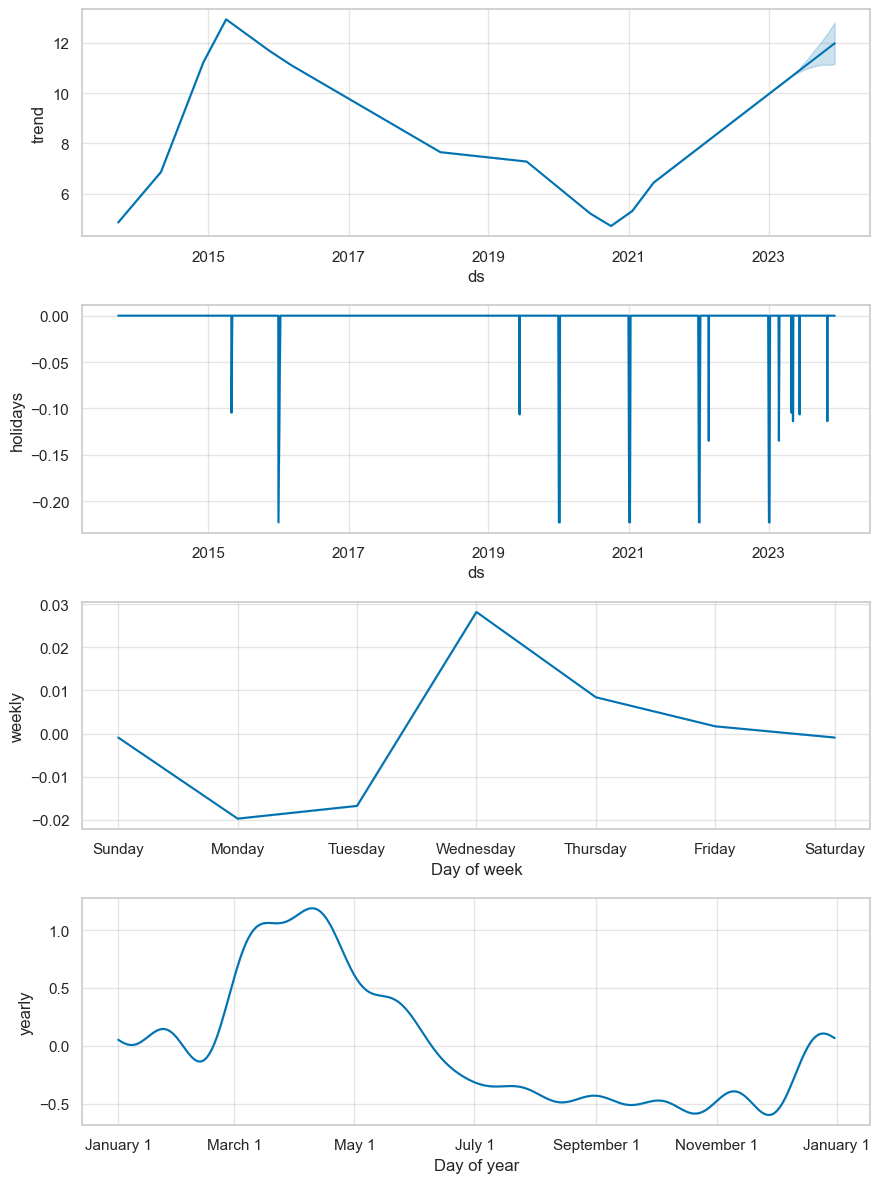

In [110]:
fig = final_test_model.plot_components(forecast)

c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


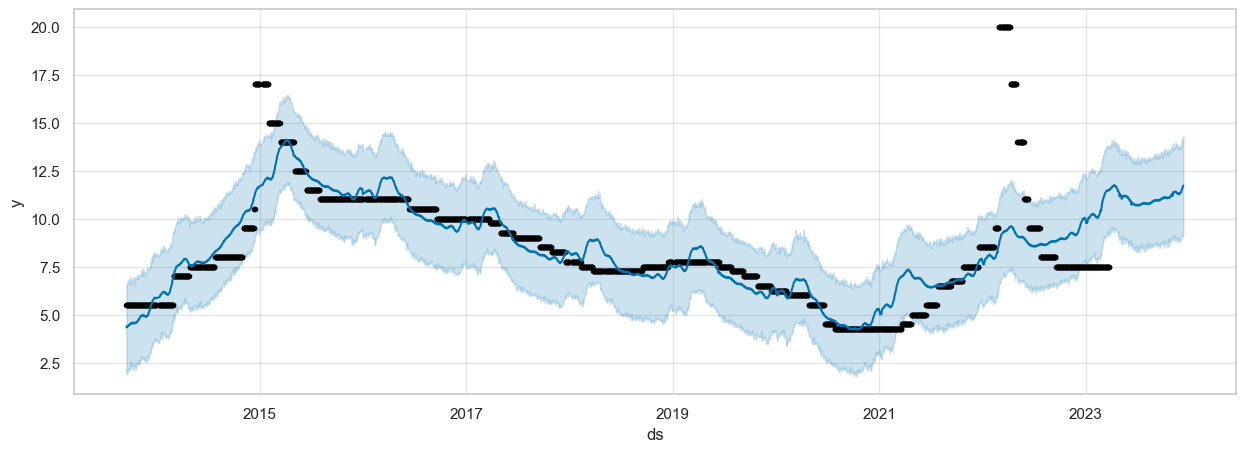

In [111]:
# смотрим график прогноза с праздниками
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = final_test_model.plot(forecast,ax=ax)
plt.show()

In [112]:
df_test_forecast_final = final_test_model.predict(df_test)
df_test_final[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
df

,ds,yhat,yhat_lower,yhat_upper
258,2024-04-01,13.722321,10.927069,16.455966
259,2024-04-02,13.742929,10.839319,16.461386
260,2024-04-03,13.805474,10.814602,16.629467
261,2024-04-04,13.802779,11.008692,16.504827
262,2024-04-05,13.812178,11.039838,16.369383


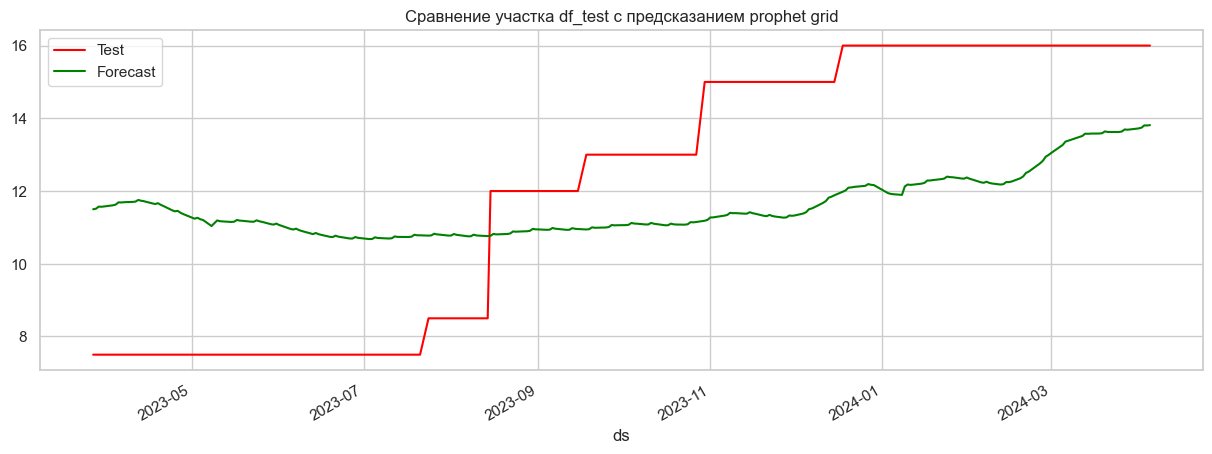

In [113]:
# сравнение участка df_test с предсказанием prophet grid
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_final.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet grid')
plt.show()

In [114]:
MAPE = mean_absolute_percentage_error(df_test['y'], df_test_final['yhat'])
print('MAPE', MAPE)

MAPE 0.2840355412487051


In [115]:
# сравниваем метрики после добавления в модель праздников 
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=df_test_final['yhat'], name='Prophet_with_grid')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet,2.933513,0.280977,9.560223,3.091961
0,Prophet_with_holidays,2.947538,0.281309,9.635085,3.104043
0,Prophet_with_grid,3.022837,0.284036,9.990449,3.160767


In [122]:
df_test_final

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Fatherland Defender's Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-03-27,10.450341,9.381417,13.775050,10.450341,10.450341,0.0,0.0,0.0,0.0,...,-0.019720,-0.019720,-0.019720,1.068436,1.068436,1.068436,0.0,0.0,0.0,11.499057
1,2023-03-28,10.456193,9.205876,13.742253,10.456193,10.456193,0.0,0.0,0.0,0.0,...,-0.016766,-0.016766,-0.016766,1.074472,1.074472,1.074472,0.0,0.0,0.0,11.513899
2,2023-03-29,10.462045,9.296519,13.876927,10.462045,10.462045,0.0,0.0,0.0,0.0,...,0.028200,0.028200,0.028200,1.081998,1.081998,1.081998,0.0,0.0,0.0,11.572243
3,2023-03-30,10.467897,9.378762,13.893864,10.467897,10.467897,0.0,0.0,0.0,0.0,...,0.008426,0.008426,0.008426,1.090897,1.090897,1.090897,0.0,0.0,0.0,11.567220
4,2023-03-31,10.473748,9.275285,13.887117,10.473748,10.473748,0.0,0.0,0.0,0.0,...,0.001689,0.001689,0.001689,1.100975,1.100975,1.100975,0.0,0.0,0.0,11.576412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,2024-04-01,12.621412,10.927069,16.455966,10.904250,14.014175,0.0,0.0,0.0,0.0,...,-0.019720,-0.019720,-0.019720,1.120629,1.120629,1.120629,0.0,0.0,0.0,13.722321
259,2024-04-02,12.627264,10.839319,16.461386,10.902702,14.028027,0.0,0.0,0.0,0.0,...,-0.016766,-0.016766,-0.016766,1.132431,1.132431,1.132431,0.0,0.0,0.0,13.742929
260,2024-04-03,12.633116,10.814602,16.629467,10.901154,14.041880,0.0,0.0,0.0,0.0,...,0.028200,0.028200,0.028200,1.144158,1.144158,1.144158,0.0,0.0,0.0,13.805474
261,2024-04-04,12.638968,11.008692,16.504827,10.895535,14.054907,0.0,0.0,0.0,0.0,...,0.008426,0.008426,0.008426,1.155385,1.155385,1.155385,0.0,0.0,0.0,13.802779


In [116]:
# Сохранение DataFrame df в файл data/df.csv
df.to_csv('../data/df.csv', index=False)

# Сохранение DataFrame df_train в файл data/df_train.csv
df_train.to_csv('../data/df_train.csv', index=False)

# Сохранение DataFrame df_test в файл data/df_test.csv
df_test.to_csv('../data/df_test.csv', index=False)
